## **Health Insurance Premium Prediction Greater than 25 + Genetical Factor**

While building the model for customers under 25, I found a big issue. The error rate was 73%, but the business needed it to be only 10%. This showed me that the model was not understanding the younger customers properly. So I decided to stop and check why this was happening.

To understand the problem better, I asked the data team for more details. We then added a new feature called the young-age genetic factor. After adding this, the model got more information and started to understand the younger group better.

But this genetic feature was only available for people under 25. So during deployment, I set genetic_risk = 0 in the Streamlit app for anyone above 25. This kept the input simple and avoided confusion. After doing this, the model worked better and gave more accurate results for all age groups.

**Problem Understanding**
  
The rising complexity of medical expenses has made it increasingly difficult for insurance companies to determine fair and accurate premium pricing.
To address this challenge, this project aims to develop a predictive machine learning model capable of estimating health insurance premiums based on individual health and lifestyle factors such as age, BMI, smoking habits, and medical history.

**Objective:**
  
- Develop a high-accuracy (>97%) predictive model. The percentage difference between 
  the predicted and actual value on a minimum of 95% of the errors should be less than 
  10%. 
- Deploy the model in the cloud so that an insurance underwriter can run it from anywhere. 
- Create an interactive Streamlit application that an underwriter can use for predictions. 

In [98]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import warnings
warnings.filterwarnings("ignore")


<h2 align="center" style="color:blue; font-weight:bold; font-size:30px;">Data Loading</h2>


In [99]:
df = pd.read_excel("premiums_rest.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [100]:
# add artificial genetical_risk column to be consistent with young model
df['Genetical_Risk'] = 0

In [101]:
df.shape

(29904, 14)

In [102]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0


<h2 align="center" style="color:blue; font-size:30px; font-weight:bold;">Exploratory Data Analysis & Data Cleaning</h2>


## **Handle Missing Values**

In [103]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [104]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

## **Handle Duplicates**

In [105]:
df.duplicated().sum()

np.int64(0)

In [106]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [107]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


## **Data Cleaning: number_of_dependants**

In [108]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-1, -3])

**I observed some negative values in number_of_dependants. To address this, I replaced them with their absolute values to ensure all entries were positive.**

In [109]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.385933,23.364184,20892.303821,0.0
std,13.412657,1.421137,24.740339,6936.813440,0.0
min,26.000000,0.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


## **1. Numeric Columns**

#####  **Univariate Analysis: Numeric Columns**

###### **Box plots for numeric columns**

In [110]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns  

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

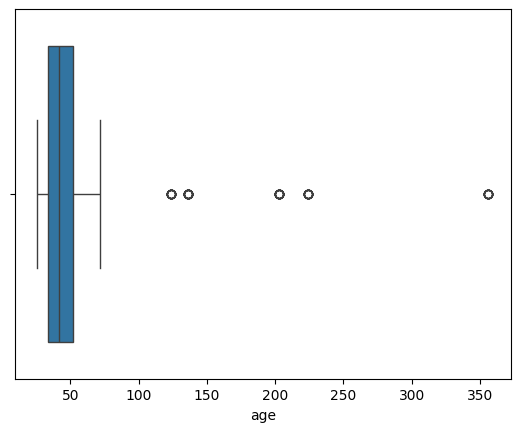

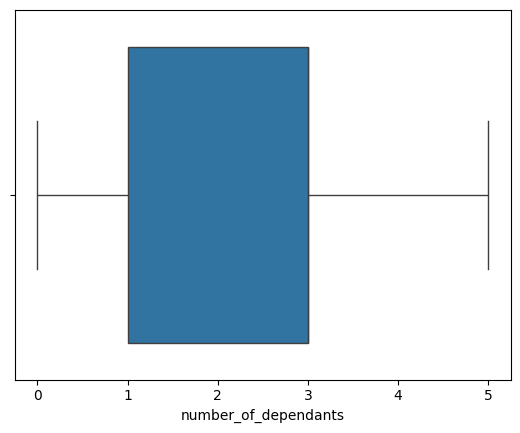

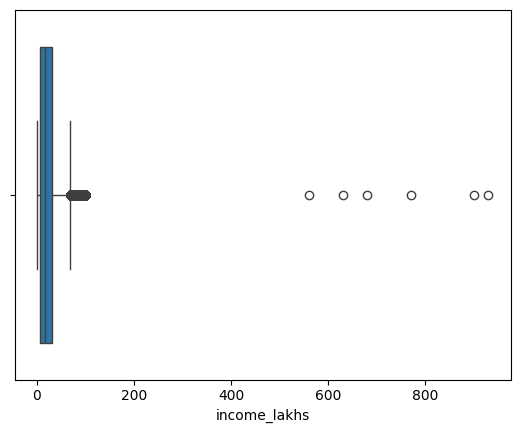

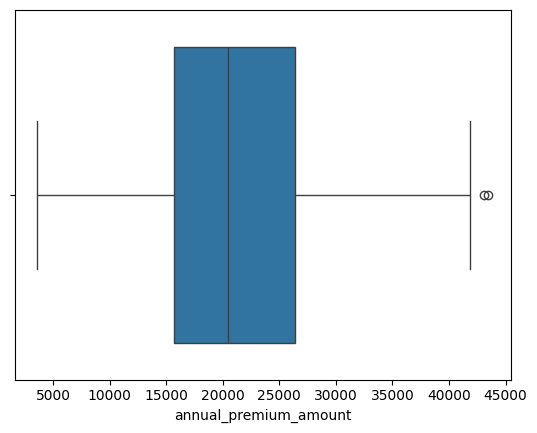

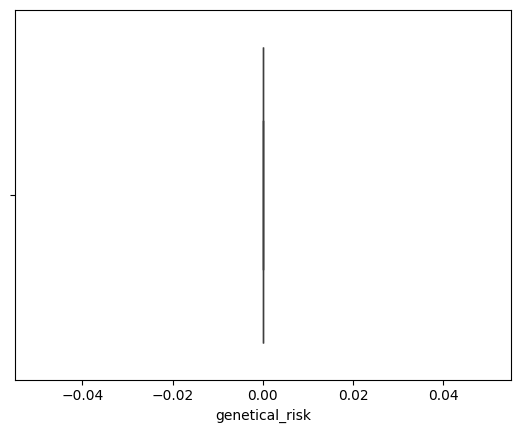

In [111]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

## **Outlier Treatment: Age Column**

In [112]:
df[df['age']>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [113]:
df1 = df[df.age<=100]
df1.age.describe()

count    29828.000000
mean        43.095380
std         11.041991
min         26.000000
25%         34.000000
50%         42.000000
75%         52.000000
max         72.000000
Name: age, dtype: float64

## **Outlier Treatment: Income Column**

In [114]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df1['income_lakhs'])
lower, upper

(-30.5, 69.5)

In [115]:
df1[df1.income_lakhs>upper].shape

(2090, 14)

**There were many legitimate records that would have been removed if I had used the IQR bounds method. so, I decided to use a simple quantile bound instead.**

In [116]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [117]:
df1[df1.income_lakhs>quantile_thresold].shape

(6, 14)

In [118]:
df2 = df1[df1.income_lakhs<=quantile_thresold].copy()
df2.shape

(29822, 14)

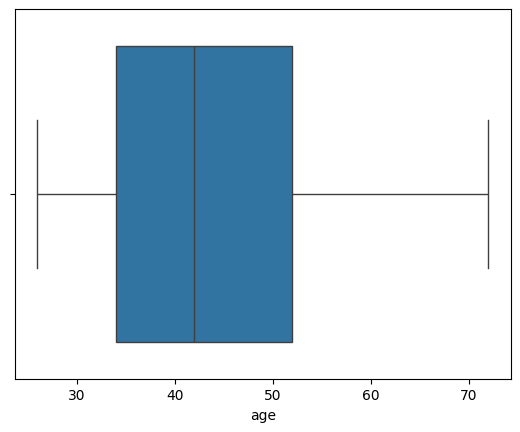

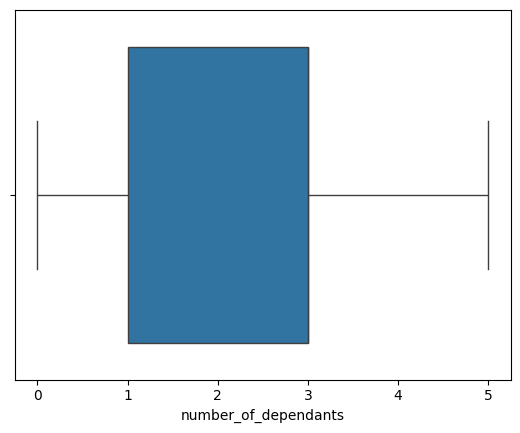

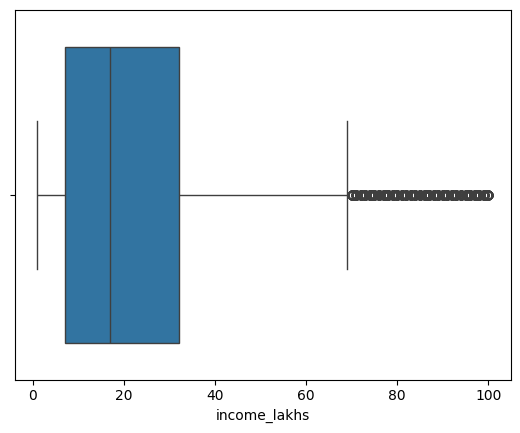

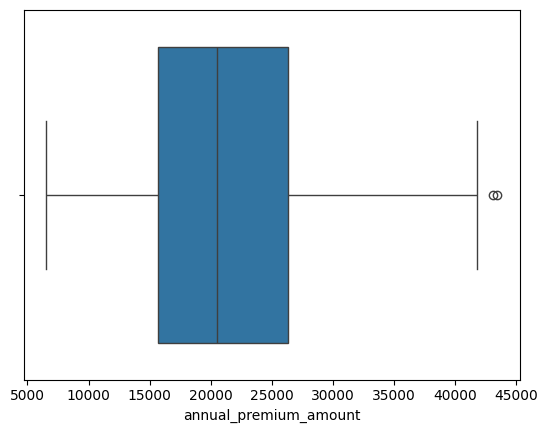

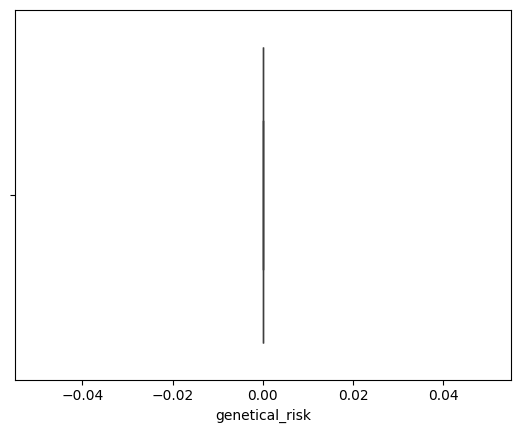

In [119]:
for col in numeric_columns:
    sns.boxplot(x=df2[col])
    plt.show()

### **Data Visualization**

IndexError: index 2 is out of bounds for axis 0 with size 2

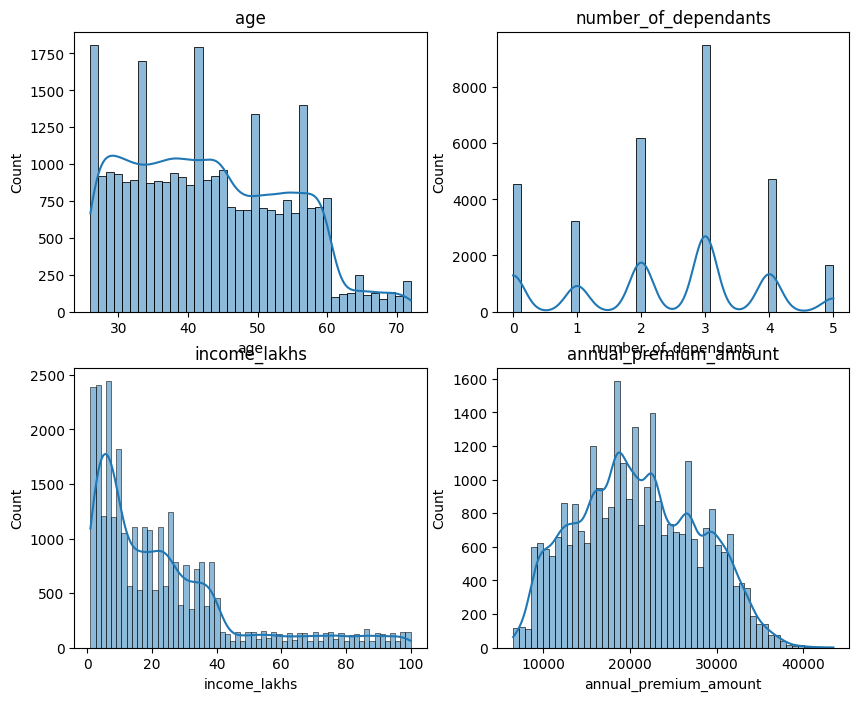

In [97]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [ ]:
df2.head(2)

## **Bivariate Analysis: Numeric Columns**

In [ ]:
numeric_columns

In [ ]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

## **2. Categorical Columns**

In [ ]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

In [ ]:
df2['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df2['smoking_status'].unique()

## **Univariate Analysis**

In [ ]:
df2.head(2)

In [ ]:
pct_count = df2['gender'].value_counts(normalize=True)*100
pct_count

In [ ]:
sns.barplot(x=pct_count.index, y=pct_count.values)

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

## **Bivariate Analysis**

In [ ]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

In [ ]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

<h2 align="center" style="color:blue; font-size:30px; font-weight:bold;">Feature Engineering</h2>


In [ ]:
df2.head(2)

## **Calculate Risk Score**

In [ ]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

## **Encode Text Columns**

In [ ]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [ ]:
df2.income_level.unique()

In [ ]:

df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [ ]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.columns

In [ ]:
df3.info()

## **Feature Selection**

In [ ]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)                

## **Calculate VIF for Multicolinearity**

In [ ]:
df4.columns

In [ ]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [ ]:
calculate_vif(X)

In [ ]:
calculate_vif(X.drop('income_level', axis="columns"))

In [ ]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop('income_level', axis="columns")

<h1 align="center" style="color:blue; font-size:30px; font-weight:bold;">Model Training</h1>


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

# **Linear Regression Model**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

def linear_regression_metrics(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    train_r2 = model.score(X_train, y_train)
    test_r2  = model.score(X_test, y_test)
    mse      = mean_squared_error(y_test, y_pred)
    rmse     = np.sqrt(mse)

    print("Linear Regression Metrics")
    print(f"  Train R² : {train_r2:.4f}")
    print(f"  Test  R² : {test_r2:.4f}")
    print(f"  MSE      : {mse:.4f}")
    print(f"  RMSE     : {rmse:.4f}")

    return {
        "model": model,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "mse": mse,
        "rmse": rmse
    }

# usage
results_lr = linear_regression_metrics(X_train, X_test, y_train, y_test)


In [ ]:
X_test.shape

In [ ]:
lr_model = results_lr["model"]


print(f'Coefficients: =======> {lr_model.coef_}')
print(f'Intercept: ==========> {lr_model.intercept_}')

In [ ]:
feature_importance = lr_model.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

# **Ridge Regression Model**

In [ ]:
def ridge_regression_metrics(X_train, X_test, y_train, y_test, alpha=1.0):
    model_rg = Ridge(alpha=alpha)
    model_rg.fit(X_train, y_train)

    y_pred = model_rg.predict(X_test)

    train_r2 = model_rg.score(X_train, y_train)
    test_r2  = model_rg.score(X_test, y_test)
    mse_rg   = mean_squared_error(y_test, y_pred)
    rmse_rg  = np.sqrt(mse_rg)

    print(f"Ridge Regression (alpha={alpha}) Metrics")
    print(f"  Train R² : {train_r2:.4f}")
    print(f"  Test  R² : {test_r2:.4f}")
    print(f"  MSE      : {mse_rg:.4f}")
    print(f"  RMSE     : {rmse_rg:.4f}")

    return {
        "train_r2": train_r2,
        "test_r2": test_r2,
        "mse": mse_rg,
        "rmse": rmse_rg
    }

# usage
ridge_results = ridge_regression_metrics(X_train, X_test, y_train, y_test, alpha=1.0)

# **XGBoost** 

In [ ]:
from xgboost import XGBRegressor
def xgb_regression_metrics(X_train, X_test, y_train, y_test,
                           n_estimators=20, max_depth=3, learning_rate=0.1, random_state=42):
    model_xgb = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=random_state
    )

    model_xgb.fit(X_train, y_train)

    y_pred = model_xgb.predict(X_test)

    train_r2 = model_xgb.score(X_train, y_train)
    test_r2  = model_xgb.score(X_test, y_test)
    mse_xgb  = mean_squared_error(y_test, y_pred)
    rmse_xgb = np.sqrt(mse_xgb)

    print(f"XGBoost Regression Metrics (n_estimators={n_estimators}, max_depth={max_depth})")
    print(f"  Train R² : {train_r2:.4f}")
    print(f"  Test  R² : {test_r2:.4f}")
    print(f"  MSE      : {mse_xgb:.4f}")
    print(f"  RMSE     : {rmse_xgb:.4f}")

    return {
        "train_r2": train_r2,
        "test_r2": test_r2,
        "mse": mse_xgb,
        "rmse": rmse_xgb
    }

# usage
xgb_results = xgb_regression_metrics(X_train, X_test, y_train, y_test,
                                     n_estimators=20, max_depth=3)

# **Hyperparameter Tuning for XGBoost using RandomizedSearchCV**

In [ ]:
def xgb_random_search_metrics(X_train, X_test, y_train, y_test):
    model_xgb = XGBRegressor()

    param_grid = {
        'n_estimators': [20, 40, 50],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
    }

    random_search = RandomizedSearchCV(
        estimator=model_xgb,
        param_distributions=param_grid,
        n_iter=10,
        cv=3,
        scoring='r2',
        random_state=42,
        n_jobs=1
    )

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    # Train/Test scores & metrics with best model
    train_r2 = best_model.score(X_train, y_train)
    test_r2  = best_model.score(X_test, y_test)

    y_pred = best_model.predict(X_test)
    mse    = mean_squared_error(y_test, y_pred)
    rmse   = np.sqrt(mse)

    print("Best Params:", random_search.best_params_)
    print(f"CV Best R² : {random_search.best_score_:.4f}")
    print("XGBoost (Best Model) Test Metrics:")
    print(f"  Train R² : {train_r2:.4f}")
    print(f"  Test  R² : {test_r2:.4f}")
    print(f"  MSE      : {mse:.4f}")
    print(f"  RMSE     : {rmse:.4f}")

    return best_model, random_search

# usage
best_xgb_model, xgb_search = xgb_random_search_metrics(X_train, X_test, y_train, y_test)

# **Model Performance Comparison**

️**Linear Regression & Ridge Regression**

R² Score (Train/Test): 0.9282 / 0.9281

MSE: 5,165,611.91

RMSE: 2,272.80

**Observation:**
Both models produced identical results, indicating that Ridge Regression’s regularization had no effect. The models performed well but failed to minimize errors effectively.
    
*******************************
**XGBoost Regression (Before Tuning)**
R² Score: 0.9782

MSE: 1,563,064.14

RMSE: 1,250.23

**Observation:**
XGBoost significantly outperformed Linear/Ridge Regression, capturing non-linear relationships better and reducing errors.
    
********************************
    
**XGBoost Regression (After Hyperparameter Tuning)**
    
Best Parameters: n_estimators = 50, max_depth = 5, learning_rate = 0.1

Best R² Score (Cross-Validation): 0.9809

**Observation:**
Fine-tuning improved accuracy further, balancing complexity and generalization effectively.

**********************************************
 **Conclusion**

Linear & Ridge Regression performed similarly, indicating that regularization was unnecessary.
    
XGBoost Regression provided much better accuracy and lower error, making it the best model.

Hyperparameter tuning further improved XGBoost’s performance, enhancing predictive power.

Final Recommendation: XGBoost is the optimal choice due to its superior accuracy, lower error, and ability to capture complex patterns.

**********************************************


In [ ]:
feature_importance = best_xgb_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [ ]:
y_pred = best_xgb_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

In [ ]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [ ]:
X_test.shape

In [ ]:
extreme_error_threshold = 10  # this threshold based on your requirements

In [ ]:

# for extreme errors: |diff_pct| >= 10
extreme_mask = results_df['diff_pct'].abs() >= extreme_error_threshold

# DataFrame with only extreme-error customers
extreme_results_df = results_df[extreme_mask]

# Percentage of extreme-error customers
extreme_errors_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
print(f"Customers with >= {extreme_error_threshold}% , error: {extreme_errors_pct:.2f}%")

# Seeing worst extreme errors (sorted by percentage difference)
extreme_results_df_sorted = extreme_results_df[abs(extreme_results_df.diff_pct)>10].sort_values("diff_pct", ascending=False)
extreme_results_df_sorted


In [ ]:
extreme_results_df_sorted.shape

##### **Here the Age Greater than 25 customers have 0.3% extreme errors which means for 0.3% customers will either overcharge or undercharge by 10% or more**

In [ ]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

In [ ]:
extreme_results_df[abs(extreme_results_df.diff_pct)>10].sort_values("diff_pct",ascending=False)

##### **There were about 4487 customers whom premium plan may overcharged or undercharged by more than 10%.**

In [ ]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

In [ ]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()
    plt.savefig('Distribution of Extreme Errors.png')

#  **Reverse Scaling**

In [ ]:
extreme_errors_df['income_level']=-1

In [ ]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

In [ ]:
df_reversed.describe()

In [ ]:
sns.histplot(df_reversed.age)
plt.savefig('age_error.png')

##### **Here the Age greater than 25 has the error 0.3% < 10% of Business Requirement. So no need Further investigation**